In [1]:
%load_ext autoreload
%autoreload 2

In [45]:
import torch as torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Subset

import torchvision as V
import torchvision.transforms as T
import torchvision.transforms.functional as TF

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
import numpy as np
import pandas as pd
import math
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

In [66]:
import rich
from rich import print
import tqdm
from dataclasses import dataclass, field
from typing import Union, Tuple, Optional

rich.reconfigure(width=120)

In [40]:
import tp4.training as training
import tp4.utils as utils
import tp4.models as models
import tp4.data as data
from tp4.data import TinyCIFAR

# Small data and deep learning
This pratical session proposes to study several techniques to improve training performance in the challenging context where few data and resources are available.

# Introduction
Assume we are in a context where few "gold" labeled data are available for training, say $\mathcal{X}_{\text{train}}\triangleq\{(x_n,y_n)\}_{n\leq N_{\text{train}}}$, where $N_{\text{train}}$ is small. A large test set $\mathcal{X}_{\text{test}}$ is available. A large amount of unlabeled data, $\mathcal{X}_{\text{nolabel}}$, is available. We also assume that we have a limited computational budget (e.g., no GPUs).

For each question, write a commented *Code* or a complete answer as a *Markdown*. When the objective of a question is to report a CNN accuracy, please use the following format to report it, at the end of the question :


| Model | Number of  epochs  | Train accuracy | Test accuracy |
|------|------|------|------|
|   XXX  | XXX | XXX | XXX |


If applicable, please add the field corresponding to the  __Accuracy on Full Data__ as well as a link to the __Reference paper__ you used to report those numbers. (You do not need to train a CNN on the full CIFAR10 dataset.)

In your final report, please keep the logs of each training procedure you used. We will only run this jupyter if we have some doubts on your implementation. 

__The total file sizes should be reasonable (feasible with 2MB only!). You will be asked to hand in the notebook, together with any necessary files required to run it if any.__


To run your experiments, you can use the same local installation as for previous TPs, or otherwise https://colab.research.google.com/.

## Training set creation

### Question 1
__Question 1 (2 points) :__ Propose a dataloader that will only use the first 100 samples of the CIFAR-10 training set. 

*Hint* : You can modify the file located at https://github.com/pytorch/vision/blob/master/torchvision/datasets/cifar.py or use the information from https://pytorch.org/vision/stable/datasets.html

This is our dataset $\mathcal{X}_{\text{train}}$, it will be used until the end of this project. The remaining samples correspond to $\mathcal{X}_{\text{nolabel}}$. The testing set $\mathcal{X}_{\text{test}}$ corresponds to the whole testing set of CIFAR-10.

In [6]:
from tp4.data import TinyCIFAR
from tp4.data import transforms

def X(mode="train", transform="minimal", size=224, length=None):
    transform = transforms[transform]
    resize = T.RandomResizedCrop(size) if mode == "train" else T.Resize(size)
    transform = T.Compose([
        resize,
        transform
    ])
    if mode == "train" or mode == "val":
        return  TinyCIFAR(root="../data", download=True, transform=transform)
    elif mode == "test":
        ret = V.datasets.cifar.CIFAR10(root="../data", train=False, download=True, transform=transform)
        if length is not None:
            return torch.utils.data.Subset(ret, np.random.randint(len(ret), size=length))
        return ret
    else:
        raise ValueError(mode)

## Testing procedure

### Question 2
__Question 2 (1.5 points) :__ Explain why the evaluation of the training procedure is difficult. Propose several solutions.


We exhibit several challenges for learning with few examples.

#### Overfitting
Certainly the main concern is that a model with reasonably many parameters such as *resnet18* overfits the few data samples.
- To help against overfitting, we can explore regularisation procedures such as weight dropout
- We can also enforce invariance such as *flip* invariance for images.
- Data augmentation can also act as a regulariser.

#### Generalisation
It is challenging for a network to draw good generalisations from very limited examples. Classical techniques include
- Data augmentation
- Using a pre-trained model, either by considering that the features computed in the middle layers are already good and retraining only the last layer(s), or by using it as a good initial start and fine tuning the whole network

#### Imbalance
Unfortunately an additional challenge arises here : classes are not uniformly represented in the training set. This is not specific to small data sets, but is particulrlay hard to tackle when few examples are present in the first place (there are only 4 examples of *ships*!).
We tackled this issue by presenting data samples proportionnaly to their scarcity. However, we observed in the trained networks that there remains imbalance in the predictions, skewed towards classes that are more present in the training set (presumably because the network is able to generalize those well, while it overfits scarcely represented classes).

In [7]:
_X = data.TinyCIFAR(root="../data")
counts = pd.Series([y for _, y in _X]).value_counts() / len(_X)
counts = pd.DataFrame(counts.values, index=np.array(_X.classes)[counts.index], columns=["frequency"])
counts

,frequency
automobile,0.16
bird,0.13
cat,0.13
truck,0.12
deer,0.11
horse,0.11
frog,0.07
dog,0.07
airplane,0.06
ship,0.04



#### Evaluation
The classical train/val separation becomes dubious in our context: the training set will be even more limited and the validation set will be a poor approximation of the actual test. This is a very concerning issue, our best solution is to mitigate variance with *K* fold cross validation, but it is not ideal either, and multiplies computation time.

# Raw approach: the baseline

In this section, the goal is to train a CNN on $\mathcal{X}_{\text{train}}$ and compare its performance with reported numbers from the litterature. You will have to re-use and/or design a standard classification pipeline. You should optimize your pipeline to obtain the best performances (image size, data augmentation by flip, ...).

The key ingredients for training a CNN are the batch size, as well as the learning rate schedule, i.e. how to decrease the learning rate as a function of the number of epochs. A possible schedule is to start the learning rate at 0.1 and decreasing it every 30 epochs by 10. In case of divergence, reduce the learning rate. A potential batch size could be 10, yet this can be cross-validated.

You can get some baselines accuracies in this paper : http://openaccess.thecvf.com/content_cvpr_2018/papers/Keshari_Learning_Structure_and_CVPR_2018_paper.pdf. Obviously, it is a different context for those researchers who had access to GPUs.

## ResNet architectures

### Answer 3

__Question 3 (4 points) :__ Write a classification pipeline for $\mathcal{X}_{\text{train}}$, train from scratch and evaluate a *ResNet-18* architecture specific to CIFAR10 (details about the ResNet-18 model, originally designed for the ImageNet dataset, can be found here: https://arxiv.org/abs/1512.03385). Please report the accuracy obtained on the whole dataset as well as the reference paper/GitHub link.

*Hint:* You can re-use the following code: https://github.com/kuangliu/pytorch-cifar. During a training of 10 epochs, a batch size of 10 and a learning rate of 0.01, one obtains 40% accuracy on $\mathcal{X}_{\text{train}}$ (\~2 minutes) and 20% accuracy on $\mathcal{X}_{\text{test}}$ (\~5 minutes).

**Answer 3**
The best result for ResNet-18 on the whole CIFAR 10 reported in the litterature is reported [here](https://paperswithcode.com/sota/stochastic-optimization-on-cifar-10-resnet-18) with [this associated paper](https://arxiv.org/abs/1907.08610), reaching an accuracy of 95.27%

| **Model**              | **Number of epochs** | **Test accuracy** | **Reference paper**                                                                   |
|------------------------|----------------------|-------------------|---------------------------------------------------------------------------------------|
| ResNet-18 / Look-ahead | 200                  | 95.27%            | [Lookahead Optimizer: k steps forward, 1 step back](https://arxiv.org/abs/1907.08610) |

Our pipeline works as follows:
- we experiment with different batch sizes (4, 10, 30, 50)
- for each of them, we define a good learning rate range with a scheme developed in Homework 1.
- we experiment with different schedulers that travel through that learning rate range (Constant learning rate, OneCycleLR, StepLR)
- we choose an input image size of 64: this is a good trade-off between computation complexity (the lower the size, the better) and the scale that ResNet expects (resnet works well for ImageNet, with images of size 224).

Then we keep the networks with the best training accuracy. This may pick overfitting network but *k*-fold cross validation was too computationnaly intensive (and did not work that well anyway). It turns out that the networks kept that way perform reasonably on the test set.

_Results_:

| Scheduler | Learning rate range            | Batch size | Train accuracy | Test accuracy |
|-----------|--------------------------------|------------|----------------|---------------|
| Step LR   | $[10^{-4}, \; 2\cdot 10^{-3}]$ | 10         | 87%            | 24.4%         |
| OneCycle  | $[10^{-4}, \; 2\cdot 10^{-3}]$ | 10         | 86%            | 24.6%         |
| OneCycle  | $[10^{-4}, \; 2\cdot 10^{-3}]$ | 4          | 83%            | 24.2%         |

*For clarity, and brievity, we only report the training for the best performing set of hyperparameters*

In [8]:
batch_size_to_lr = {
    4: (0.0001, 0.01),
    10: (0.0002, 0.004),
    30: (0.001, 0.01),
    50: (0.0005, 0.007)
}

Files already downloaded and verified
Files already downloaded and verified


Epoch 01/50 | Average loss 2.37 | Accuracy 18.0% | lr 4.0e-03 | Test loss 2.33 | Test accuracy 13.5%

Epoch 04/50 | Average loss 2.30 | Accuracy 28.0% | lr 4.0e-03 | Test loss 5.16 | Test accuracy 12.2%

Epoch 07/50 | Average loss 1.96 | Accuracy 32.0% | lr 3.0e-03 | Test loss 2.78 | Test accuracy 20.5%

Epoch 10/50 | Average loss 1.97 | Accuracy 38.0% | lr 2.2e-03 | Test loss 2.80 | Test accuracy 17.7%

Epoch 13/50 | Average loss 1.56 | Accuracy 39.0% | lr 2.2e-03 | Test loss 2.62 | Test accuracy 18.7%

Epoch 16/50 | Average loss 1.42 | Accuracy 58.0% | lr 1.6e-03 | Test loss 2.76 | Test accuracy 18.3%

Epoch 19/50 | Average loss 1.29 | Accuracy 60.0% | lr 1.6e-03 | Test loss 2.70 | Test accuracy 20.5%

Epoch 22/50 | Average loss 1.16 | Accuracy 64.0% | lr 1.2e-03 | Test loss 2.68 | Test accuracy 21.5%

Epoch 25/50 | Average loss 1.27 | Accuracy 55.0% | lr 8.9e-04 | Test loss 2.80 | Test accuracy 21.0%

Epoch 28/50 | Average loss 1.17 | Accuracy 61.0% | lr 8.9e-04 | Test loss 2.61 | Test accuracy 25.3%

Epoch 31/50 | Average loss 1.08 | Accuracy 64.0% | lr 6.6e-04 | Test loss 2.65 | Test accuracy 23.7%

Epoch 34/50 | Average loss 0.90 | Accuracy 71.0% | lr 6.6e-04 | Test loss 2.64 | Test accuracy 24.3%

Epoch 37/50 | Average loss 0.70 | Accuracy 79.0% | lr 4.9e-04 | Test loss 2.76 | Test accuracy 24.8%

Epoch 40/50 | Average loss 0.88 | Accuracy 76.0% | lr 3.6e-04 | Test loss 2.85 | Test accuracy 24.0%

Epoch 43/50 | Average loss 0.92 | Accuracy 72.0% | lr 3.6e-04 | Test loss 2.79 | Test accuracy 24.5%

Epoch 46/50 | Average loss 0.94 | Accuracy 69.0% | lr 2.7e-04 | Test loss 2.87 | Test accuracy 23.8%

Epoch 49/50 | Average loss 0.70 | Accuracy 80.0% | lr 2.7e-04 | Test loss 2.83 | Test accuracy 24.3%

Epoch 50/50 | Average loss 0.92 | Accuracy 72.0% | lr 2.0e-04 | Test loss 2.85 | Test accuracy 24.8%

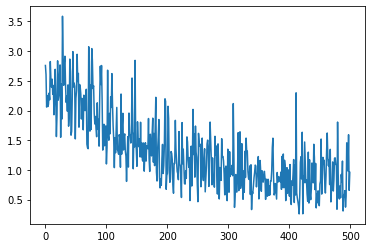

In [9]:
baseline = models.ResNet18()

loss_hist = training.train_stepLR(
    baseline,
    X("train", "minimal", size=64),
    batch_size=10,
    lrs=batch_size_to_lr[10],
    num_epochs=50,
    test_set=X("test", "minimal", size=64, length=600))

plt.plot(loss_hist)
plt.show()

In [10]:
test_loss, test_accuracy = training.test(baseline, X("test", "minimal", size=64), batch_size=25)
print(f"Test loss {test_loss:.2f} | Test accuracy {test_accuracy * 100: 03.1f}%")

Files already downloaded and verified


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 400/400 [01:30<00:00,  4.40it/s]


Test loss 2.88 | Test accuracy  24.4%

# Transfer learning

We propose to use pre-trained models on a classification task, in order to improve the results of our setting.

## ImageNet features

### Answer 4

Now, we will use a model pre-trained on ImageNet and see how well it performs on CIFAR. A list of ImageNet pre-trained models is available on : https://pytorch.org/vision/stable/models.html

__Question 4 (3 points) :__ Pick a model from the list above, adapt it for CIFAR and retrain its final layer (or a block of layers, depending on the resources to which you have access to). Report its accuracy.

To be able to compare against no pre-training, we pick the same *ResNet18* model. An important detail is that since this model was pre-trained over *224x224* images, we must resize CIFAR10 images to a corresponding size. This does make computations more expensive, but is crucial to obtain good results.

We cannot repeat the same hyperparameter validation process as without pretraining, as most set of hyperparameters reach 100% on the training data which is obviously an overfit. Instead we bite the bullet and perform *K*-fold cross validation with $K=5$. To limit the number of hyperparameters to tune, we reuse the best performing hyperparameters without pretraining, that is a batch size of $10$, a learning rate range between $10^{-4}$ and $2\cdot10^{-3}$, and a StepLR scheduler. We perform cross validation to determine the number of layers to freeze and the number of layers to fine tune. We obtain that we should freeze the last fully connected layer, and *layer4* as well.

Finally we train our model on the whole training set with the set of hyperparameters above. This yields an accuracy on the whole CIFAR10 of $53.4$%.

In [11]:
pretrained = V.models.resnet18(pretrained=True, progress=True)
for name, param in pretrained.state_dict().items():
    if not any(name.startswith(layer) for layer in ("layer4", "fc")):
        param.requires_grad = False
pretrained.fc = nn.Linear(pretrained.fc.in_features, 10)
pretrained = pretrained.to(device)

Files already downloaded and verified


Epoch 01/50 | Average loss 2.30 | Accuracy 18.0% | lr 1.0e-03

Epoch 04/50 | Average loss 1.80 | Accuracy 41.0% | lr 1.0e-03

Epoch 07/50 | Average loss 1.59 | Accuracy 50.0% | lr 7.9e-04

Epoch 10/50 | Average loss 1.29 | Accuracy 57.0% | lr 6.3e-04

Epoch 13/50 | Average loss 1.11 | Accuracy 67.0% | lr 6.3e-04

Epoch 16/50 | Average loss 0.82 | Accuracy 80.0% | lr 5.0e-04

Epoch 19/50 | Average loss 0.95 | Accuracy 73.0% | lr 5.0e-04

Epoch 22/50 | Average loss 0.88 | Accuracy 73.0% | lr 4.0e-04

Epoch 25/50 | Average loss 0.84 | Accuracy 71.0% | lr 3.2e-04

Epoch 28/50 | Average loss 0.79 | Accuracy 78.0% | lr 3.2e-04

Epoch 31/50 | Average loss 0.78 | Accuracy 73.0% | lr 2.5e-04

Epoch 34/50 | Average loss 0.63 | Accuracy 87.0% | lr 2.5e-04

Epoch 37/50 | Average loss 0.79 | Accuracy 84.0% | lr 2.0e-04

Epoch 40/50 | Average loss 0.65 | Accuracy 85.0% | lr 1.6e-04

Epoch 43/50 | Average loss 0.59 | Accuracy 82.0% | lr 1.6e-04

Epoch 46/50 | Average loss 0.53 | Accuracy 86.0% | lr 1.3e-04

Epoch 49/50 | Average loss 0.69 | Accuracy 81.0% | lr 1.3e-04

Epoch 50/50 | Average loss 0.64 | Accuracy 85.0% | lr 1.0e-04

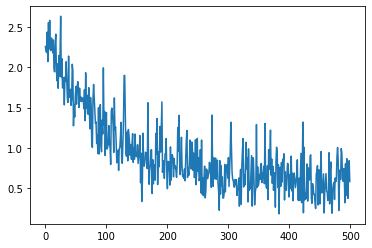

In [15]:
loss_hist = training.train_stepLR(
    pretrained,
    X("train", "minimal", size=224),
    batch_size=10,
    lrs=(1e-4, 1e-3),
    num_epochs=50,
    test_set=None,
    parameters=list(pretrained.layer4.parameters()) + list(pretrained.fc.parameters())
)
plt.plot(loss_hist)
plt.show()

In [17]:
test_loss, test_accuracy = training.test(pretrained, X("test", "minimal", size=224), batch_size=10)
print(f"Test loss {test_loss:04.2f} | Accuracy : {100 * test_accuracy:04.1f}%")

Files already downloaded and verified


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [11:39<00:00,  1.43it/s]


Test loss 1.33 | Accuracy : 53.4%

# Incorporating priors
Geometrical priors are appealing for image classification tasks. 
A color image $x$ can be seen as a function: $\mathbb{S}\rightarrow\mathbb{R}^3$, where $\mathbb{S} \subset \mathbb{R}^2$ is the image support.
Let us consider transformations $\mathcal{T}$ of possible inputs $x$. For instance, if an image had infinite support, a translation $\mathcal{T}_a$ of an image $x$ by a shift $a$ would lead to a new infinite-support image $\mathcal{T}_a(x)$, described at each pixel $u$ by :

$$\forall u, \mathcal{T}_a(x)(u)=x(u-a)\,.$$

#### Answer 5


__Question 5 (1.5 points) :__ Explain the issues when dealing with translations, rotations, scaling effects, color changes on $32\times32$ images. Propose several ideas to tackle them.

There are several issues, that all more or less stem from the fact that removing information from 32x32 pixels can quickly lose the information about the class.

1. For rotations of non $\pi/4$-multiples and non integer translations, how can we compute $\mathcal{T}_a$ and $\mathcal{R}_{\theta}$ ?
We of course can interpolate. Different interpolations are possible. The most precise is the Shannon interpolate -- but we do not have to complicate things to such extent, a simple binilear interpolation should be fine (and is much faster to compute)
2. Again for rotation and translations, even when interpolating, how can we deal with values out of the convex hull of the image support. A natural idea is to pad with $0$s outside of the support, but this can quickly remove too much information. We thus must restrict the transformations to small angles and small deltas.
3. A challenge with color changes is finding adequate invariance. For 32x32 images, a too abrupt colour distortion may remove too much information to retrieve the image class.

More generally, the way that we deal with the above mentioned issues is by projecting the images onto larger sizes (we chose 64x64), and limiting ourselves to small transformations.

## Data augmentations

#### Answer 6

__Question 6 (3 points) :__ Propose a set of geometric transformations beyond translation, and incorporate them in your training pipeline. Train the model of the __Question 3__ with them and report the accuracies.
You can use tools from https://pytorch.org/vision/stable/transforms.html 

- We can go a bit further than translations and add affine transformations, again with small coefficients. 
- As mentioned earlier, we can add small rotations.
- The network should be invariant to horizontal symmetry : we can add "flipped" images
- Usually, colour information is quite redundant for humans to classify an image (gray is enough, fewer levels is enough, etc). Thus we should make the network robust to aggressive colour changes
    - Increase the constrast
    - Decrease the constrast
    - Small noise
    - Other thousands transformations that pytorch conveniently provide
   
The colour augmentation reflect not so much an invariance that we want, but rather provides regularisation.

Files already downloaded and verified
Files already downloaded and verified


Epoch 01/50 | Average loss 2.46 | Accuracy 10.0% | lr 4.0e-03 | Test loss 2.30 | Test accuracy 12.8%

Epoch 04/50 | Average loss 2.51 | Accuracy 18.0% | lr 4.0e-03 | Test loss 3.04 | Test accuracy 17.5%

Epoch 07/50 | Average loss 2.33 | Accuracy 24.0% | lr 3.0e-03 | Test loss 2.48 | Test accuracy 15.8%

Epoch 10/50 | Average loss 2.32 | Accuracy 26.0% | lr 2.2e-03 | Test loss 2.38 | Test accuracy 18.3%

Epoch 13/50 | Average loss 2.03 | Accuracy 28.0% | lr 2.2e-03 | Test loss 2.65 | Test accuracy 20.5%

Epoch 16/50 | Average loss 1.83 | Accuracy 34.0% | lr 1.6e-03 | Test loss 2.32 | Test accuracy 19.5%

Epoch 19/50 | Average loss 1.77 | Accuracy 36.0% | lr 1.6e-03 | Test loss 2.28 | Test accuracy 22.2%

Epoch 22/50 | Average loss 1.86 | Accuracy 33.0% | lr 1.2e-03 | Test loss 2.19 | Test accuracy 26.3%

Epoch 25/50 | Average loss 1.84 | Accuracy 33.0% | lr 8.9e-04 | Test loss 2.38 | Test accuracy 21.2%

Epoch 28/50 | Average loss 1.65 | Accuracy 41.0% | lr 8.9e-04 | Test loss 2.27 | Test accuracy 23.5%

Epoch 31/50 | Average loss 1.68 | Accuracy 42.0% | lr 6.6e-04 | Test loss 2.21 | Test accuracy 27.5%

Epoch 34/50 | Average loss 1.73 | Accuracy 38.0% | lr 6.6e-04 | Test loss 2.22 | Test accuracy 26.5%

Epoch 37/50 | Average loss 1.67 | Accuracy 45.0% | lr 4.9e-04 | Test loss 2.27 | Test accuracy 25.0%

Epoch 40/50 | Average loss 1.59 | Accuracy 48.0% | lr 3.6e-04 | Test loss 2.23 | Test accuracy 26.2%

Epoch 43/50 | Average loss 1.69 | Accuracy 43.0% | lr 3.6e-04 | Test loss 2.22 | Test accuracy 27.7%

Epoch 46/50 | Average loss 1.62 | Accuracy 45.0% | lr 2.7e-04 | Test loss 2.20 | Test accuracy 27.7%

Epoch 49/50 | Average loss 1.38 | Accuracy 58.0% | lr 2.7e-04 | Test loss 2.20 | Test accuracy 29.2%

Epoch 50/50 | Average loss 1.75 | Accuracy 42.0% | lr 2.0e-04 | Test loss 2.19 | Test accuracy 26.3%

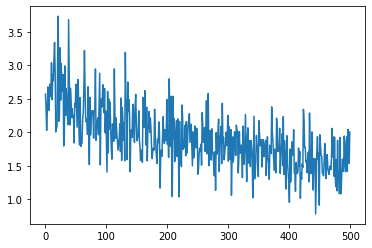

In [41]:
augmented = models.ResNet18()

loss_hist = training.train_stepLR(
    augmented,
    X("train", "colour_and_geometric", size=64),
    batch_size=10,
    lrs=batch_size_to_lr[10],
    num_epochs=50,
    test_set=X("test", "minimal", size=64, length=600))

plt.plot(loss_hist)
plt.show()

In [42]:
test_loss, test_accuracy = training.test(augmented, X("test", "minimal", size=64), batch_size=25)
print(f"Test loss {test_loss:04.2f} | Accuracy : {100 * test_accuracy:04.1f}%")

Files already downloaded and verified


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 400/400 [01:20<00:00,  4.97it/s]


Test loss 2.27 | Accuracy : 26.2%

Files already downloaded and verified


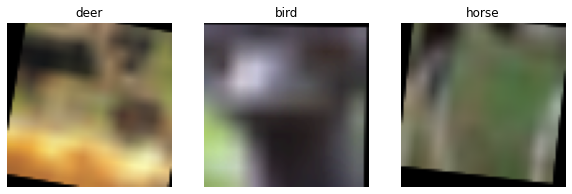

In [43]:
utils.visualize(X("train", "colour_and_geometric", size=64))

# Conclusions

__Question 7 (5 points) :__ Write a short report explaining the pros and the cons of each method you implemented. 25% of the grade of this project will correspond to this question, thus, it should be done carefully. In particular, please add a plot that will summarize all your numerical results.

We found that deep training under this setting, with scarce label data, was quite challenging and tricky.

One of the most prominent difficulty, across all methods, was to evaluate the method (assuming we did not have the remaining of CIFAR10). The classical train/val separation was here either impossible or required duplicated computational effort through $K$-fold cross validation (which does not entirely solve the issue anyway).

**Overfitting**
Because of the above mentioned point, it was especially difficult to detect and avoid overfitting.
- For the baseline, we did not have many regularisations to use. We only limited training time.
- For pretraining, overfitting was a massive issue. The initial network is good enough that the training is able to reach 100% accuracy fast enough. Our approach to regularise was two-fold
    - pick a smallish learning rate
    - only train a limited number of layers
- For the last method, data augmentation is in and of itself a regularisation method. We did not have to take specific additional steps.

**Imbalance**
The initial dataset is very much non uniform in its class representation. This can severely skew the network towards the most represented classes. We implemented a rebalancing scheme that present samples at a rate inversely proportional to their label frequency in the dataset.
- The baseline is very sensitive to this issue. Even with the rebalancing correction, the baseline was skewed towards classes more represented in the training set.
- The pretrained model was more able to mitigate this issue, as it can implicitly draw inference from more examples (those on which it was pretrained).

**Training time**
- The baseline is the most bare approach, and accordingly the fastest -- although our grid-search method to tune hyperparameters was computionnally intensive.
- The data augmentation only adds a limited overhead to the training. This was also fast.
- Pretraining should not add an overhead besides download time, but here we also had to increase image size to match the input shape of ImageNet. This slowed down the training significantly. However in terms of number of epochs, the pretrained model reached good performance (40%+ accuracy) very fast (5 epochs), while the other methods need 20 epochs to reach their best.


**Performance**
- The baseline is unsurprinsingly the worst method
- The pretrained model is steps ahead of the other methods. Even without tuning parameters very carefully, we reached 40%+ accuracy easily.
- The data augmented model only improved the baseline a little bit. However, one must note that augmented models gave much more leeway in hyperparameter choices, while the baseline fell to 20% accuracy for all but a few well chosen set of hyperparameters.
- We also tested pretraining with data augmentation. This showed more visible improvements, reaching 58.1% accuracy!

| **Model**              | **Batch size** | **Scheduler** | **Learning rate**               | **Number of epochs** | **Test accuracy** |
|------------------------|----------------|---------------|---------------------------------|----------------------|-------------------|
| Baseline               | 10             | StepLR        | $[10^{-4}$,   $2 \cdot 10^{-3}]$   | 50                   | 24.4%             |
| Augmented              | 10             | StepLR        | $[10^{-4}$,   $2 \cdot 10^{-3}]$ | 50                   | 26.2              |
| Pretrained             | 10             | StepLR        | $[10^{-4}$,   $10^{-3}]$         | 50                   | 53.4%             |
| Pretrained + Augmented | 10             | StepLR        | $[10^{-4}$,   $10^{-3}]$         | 50                   | 58.1%             |

# Weak supervision

__Bonus \[open\] question (up to 4 points) :__ Pick a weakly supervised method that will potentially use $\mathcal{X}_{\text{nolabel}}\cup\mathcal{X}_{\text{train}}$ to train a model (a subset of $\mathcal{X}_{\text{nolabel}}$ is also fine). Evaluate it and report the accuracies. You should be careful in the choice of your method, in order to avoid heavy computational effort.

We implement the [FixMatch](https://arxiv.org/abs/2001.07685) regularization scheme. To the usual classification loss for the labeled data, we add a regularization term :
- the network is trained as usual on the labeled data
- the unlabeled images undergo both a *weak* augmentation (simple geometric transformations) and a *strong* augmentation (transformations which distort the images more, here we use `RandAugment` with a large magnitude)
- pseudo-labels are generated from the predictions on the weakly transformed images. We only keep those for which the confidence is over a chosen threshold
- predictions are generated using the network on the strongly transformed images
- the regularization loss is the cross entropy loss between the predictions and the pseudo-targets

This approach enforces that the network is robust to strong transformations of the images, which is intended to help generalization.

**DISCLAIMER** We obtain an accuracy of 25% with and without using FixMatch. We did not manage to improve the generalisation using the unlabeled data.

In [46]:
transform_val = T.Compose([
        T.ToTensor(),
        T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
])

In [47]:
transform_labeled = T.Compose([
        T.RandomHorizontalFlip(),
        T.RandomCrop(size=32,padding=4),
        T.ToTensor(),
        T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
])

In [48]:
class TransformFixMatch(object):
    def __init__(self, magnitude):
        self.weak = transform_labeled
        self.strong = T.Compose([
            T.RandomHorizontalFlip(),
            T.RandomCrop(size=32, padding=4),
            T.RandAugment(num_ops=2, magnitude=magnitude),
            T.ToTensor(),
            T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
        
    def __call__(self, x):
        weak = self.weak(x)
        strong = self.strong(x)
        return weak, strong

In [50]:
X_train = TinyCIFAR(root="../data", download=True, transform=transform_labeled)

X_test = V.datasets.cifar.CIFAR10(root="../data", train=False, download=True, transform=transform_val)
X_test_small = torch.utils.data.Subset(X_test, np.random.randint(len(X_test), size=1000))

Files already downloaded and verified
Files already downloaded and verified


In [52]:
X_nolabel = data.CIFARnoLabel(root="../data", download=True, transform=TransformFixMatch(magnitude=10))

Files already downloaded and verified


In [63]:
def train_WS(
    net,
    train_set,
    num_epochs=20,
    batch_size=30,
    lr=1e-3,
    schedule=False,
    parameters=None,
    test_set=None,
    threshold=0.7,
    lambda_loss=1.0,
    unlab_factor=5,
):
    labeled_trainloader = DataLoader(
    X_train,
    shuffle=True,
    batch_size=batch_size,
    drop_last=False)

    unlabeled_trainloader = DataLoader(
        X_nolabel,
        shuffle=True,
        batch_size=batch_size*unlab_factor,
        drop_last=True)

    criterion = nn.CrossEntropyLoss()
    if parameters is None:
        parameters = list(net.parameters())

    for param in net.parameters():
        param.requires_grad = False
    for param in parameters:
        param.requires_grad = True

    optimizer = optim.SGD(parameters, lr=lr, momentum=0.9, weight_decay= 0.0005,nesterov=True)

    if schedule:
        T_max = num_epochs * (len(labeled_trainloader)//batch_size + 1)
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max)

    logging_frequency = 1 + (num_epochs - 1) // 10
    loss_hist = []
    for epoch in tqdm.tqdm(range(num_epochs)):
        net.train()

        sum_loss = 0.0
        correct = 0

        correct_u = 0
        tries_u = 0

        dataloader_iterator = iter(unlabeled_trainloader)

        for X, y in labeled_trainloader:
            X = X.to(device)
            y = y .to(device)

            optimizer.zero_grad()
            y_pred = net(X)
            loss_label = criterion(y_pred, y)


            sum_loss += loss_label.item()
            _, arg_pred = y_pred.max(1)
            correct += arg_pred.eq(y).sum().item()

            loss_nolabel = 0
            if epoch >= 5:
                try:
                    X_w, X_s = next(dataloader_iterator)
                except StopIteration:
                    dataloader_iterator = iter(unlabeled_trainloader)
                    X_w, X_s = next(dataloader_iterator)

                optimizer.zero_grad()

                X_w = X_w.to(device)
                X_s = X_s.to(device)

                ## generate the pseudo labels and select those above the threshold
                y_pred_w = net(X_w)

                pseudo_label = torch.softmax(y_pred_w.detach(), dim=-1)
                max_probs, targets_u = torch.max(pseudo_label.detach(), dim=-1)
                mask = max_probs.ge(threshold)

                if mask.sum() > 1:
                    ## predict on the strong dataset
                    y_pred_s = net(X_s[mask])

                    ## compute the regularization loss
                    loss_nolabel = (criterion(y_pred_s, targets_u[mask])).sum() / X_w.shape[0]

                    _, cat_pred_s = torch.max(y_pred_s.detach(), dim=-1)
                    correct_u += cat_pred_s.eq(targets_u[mask]).sum().item()
                    tries_u += mask.sum()

            loss = loss_label + lambda_loss * loss_nolabel
            loss.backward()
            optimizer.step()

    if schedule:
        scheduler.step()
    avg_loss = sum_loss / len(labeled_trainloader)
    accuracy = correct / len(train_set)

    loss_hist.append(avg_loss)
    if test_set is not None:
        if schedule:
            (lr,) = scheduler.get_last_lr()
        if epoch == num_epochs - 1 or epoch % logging_frequency == 0:
            test_loss, test_accuracy = test(net, test_set, batch_size, progress=False)

            rprint(
              epoch_repr(
                  epoch + 1,
                  num_epochs,
                  avg_loss,
                  accuracy,
                  lr,
                  test_loss,
                  test_accuracy,
              )
            )
            rprint(f"Unlabeled consistency: {correct_u}/{tries_u}")

    return loss_hist

In [64]:
resnet18_fixmatch = V.models.resnet18(pretrained=False)

num_ftrs = resnet18_fixmatch.fc.in_features
resnet18_fixmatch.fc = nn.Linear(num_ftrs, 10)
resnet18_fixmatch = resnet18_fixmatch.to(device)

In [ ]:
loss_hist = train_WS(
        resnet18_fixmatch,
        X_train,
        batch_size=10,
        lr=0.005,
        num_epochs=200,
        parameters = None,
        schedule=True,
        test_set = X_test_small,
        threshold = 0.90,
        lambda_loss = 1.0,
        unlab_factor = 30,
)
plt.plot(loss_hist)
plt.show()

In [ ]:
test_loss, test_accuracy = test(resnet18_fixmatch, X_test, batch_size=30)
print(f"Test loss {test_loss:04.2f} | Accuracy : {100 * test_accuracy:04.1f}%")

Testing without the regularization (`lambda_loss = 0.`):

In [ ]:
resnet18_fixmatch = V.models.resnet18(pretrained=False)

num_ftrs = resnet18_fixmatch.fc.in_features
resnet18_fixmatch.fc = nn.Linear(num_ftrs, 10)
resnet18_fixmatch = resnet18_fixmatch.to(device)

In [ ]:
loss_hist = train_WS(
        resnet18_fixmatch,
        X_train,
        batch_size=10,
        lr=0.005,
        num_epochs=200,
        parameters = None,
        schedule=True,
        test_set = X_test_small,
        threshold = 0.90,
        lambda_loss = 0.0,
        unlab_factor = 30,
)
plt.plot(loss_hist)
plt.show()

In [ ]:
test_loss, test_accuracy = test(resnet18_fixmatch, X_test, batch_size=30)
print(f"Test loss {test_loss:04.2f} | Accuracy : {100 * test_accuracy:04.1f}%")

We obtain an accuracy of 25% with and without using FixMatch. We did not manage to improve the generalisation using the unlabeled data.